# Forefcasting Sunspots (Kaggle)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import config
print(tf.__version__)

tf.compat.v1.keras.backend.set_session(config.SESS)

2.3.0


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-27 22:41:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.122.128, 64.233.177.128, 2607:f8b0:4002:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.06s   

2020-09-27 22:41:21 (1.21 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



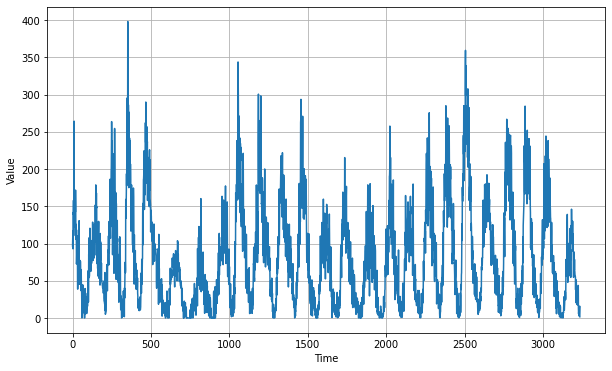

In [7]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 15ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

12/12 [==============================] - 0s 17ms/step - loss: 25.3411 - mae: 25.8357
Epoch 84/100
12/12 [==============================] - 0s 17ms/step - loss: 22.7958 - mae: 23.2897
Epoch 85/100
12/12 [==============================] - 0s 17ms/step - loss: 60.1942 - mae: 60.6923
Epoch 86/100
12/12 [==============================] - 0s 18ms/step - loss: 54.4159 - mae: 54.9142
Epoch 87/100
12/12 [==============================] - 0s 17ms/step - loss: 50.8035 - mae: 51.3014
Epoch 88/100
12/12 [==============================] - 0s 20ms/step - loss: 62.0490 - mae: 62.5473
Epoch 89/100
12/12 [==============================] - 0s 17ms/step - loss: 52.6484 - mae: 53.1465
Epoch 90/100
12/12 [==============================] - 0s 18ms/step - loss: 50.9645 - mae: 51.4620
Epoch 91/100
12/12 [==============================] - 0s 17ms/step - loss: 61.7672 - mae: 62.2654
Epoch 92/100
12/12 [==============================] - 0s 17ms/step - loss: 56.2754 - mae: 56.7738
Epoch 93/100
12/12 [=============

(1e-08, 0.0001, 0.0, 60.0)

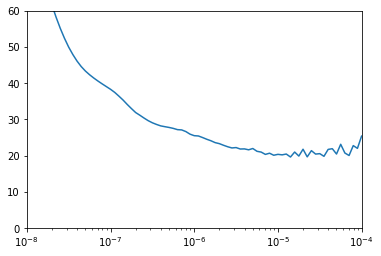

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
# tf.keras.backend.clear_session()
tf.compat.v1.keras.backend.set_session(config.SESS)
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 9ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 9ms/step - loss: 25.7614 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 9ms/step - loss: 22.0775 - mae: 22.5712
Epoch 4/500
30/30 [==============================] - 0s 9ms/step - loss: 20.4769 - mae: 20.9698
Epoch 5/500
30/30 [==============================] - 0s 9ms/step - loss: 19.7073 - mae: 20.1998
Epoch 6/500
30/30 [==============================] - 0s 8ms/step - loss: 19.3153 - mae: 19.8075
Epoch 7/500
30/30 [==============================] - 0s 9ms/step - loss: 18.6841 - mae: 19.1762
Epoch 8/500
30/30 [==============================] - 0s 9ms/step - loss: 18.1961 - mae: 18.6877
Epoch 9/500
30/30 [==============================] - 0s 9ms/step - loss: 18.0856 - mae: 18.5772
Epoch 10/500
30/30 [==============================] - 0s 10ms/step - loss: 20.0994 - mae: 20.5915
Epoch 11/500
30/30 [==================

30/30 [==============================] - 0s 9ms/step - loss: 16.3282 - mae: 16.8167
Epoch 86/500
30/30 [==============================] - 0s 9ms/step - loss: 16.4247 - mae: 16.9134
Epoch 87/500
30/30 [==============================] - 0s 9ms/step - loss: 16.7881 - mae: 17.2774
Epoch 88/500
30/30 [==============================] - 0s 9ms/step - loss: 16.8490 - mae: 17.3387
Epoch 89/500
30/30 [==============================] - 0s 9ms/step - loss: 16.4946 - mae: 16.9835
Epoch 90/500
30/30 [==============================] - 0s 14ms/step - loss: 16.3136 - mae: 16.8022
Epoch 91/500
30/30 [==============================] - 0s 10ms/step - loss: 16.3335 - mae: 16.8221
Epoch 92/500
30/30 [==============================] - 0s 10ms/step - loss: 16.3737 - mae: 16.8619
Epoch 93/500
30/30 [==============================] - 0s 9ms/step - loss: 16.3041 - mae: 16.7928
Epoch 94/500
30/30 [==============================] - 0s 9ms/step - loss: 16.2589 - mae: 16.7473
Epoch 95/500
30/30 [====================

30/30 [==============================] - 0s 9ms/step - loss: 15.9533 - mae: 16.4421
Epoch 169/500
30/30 [==============================] - 0s 9ms/step - loss: 15.7753 - mae: 16.2637
Epoch 170/500
30/30 [==============================] - 0s 10ms/step - loss: 15.7873 - mae: 16.2758
Epoch 171/500
30/30 [==============================] - 0s 9ms/step - loss: 15.7375 - mae: 16.2259
Epoch 172/500
30/30 [==============================] - 0s 9ms/step - loss: 15.8092 - mae: 16.2979
Epoch 173/500
30/30 [==============================] - 0s 10ms/step - loss: 15.8598 - mae: 16.3488
Epoch 174/500
30/30 [==============================] - 0s 9ms/step - loss: 15.9327 - mae: 16.4215
Epoch 175/500
30/30 [==============================] - 0s 9ms/step - loss: 15.8425 - mae: 16.3312
Epoch 176/500
30/30 [==============================] - 0s 9ms/step - loss: 15.8262 - mae: 16.3153
Epoch 177/500
30/30 [==============================] - 0s 10ms/step - loss: 15.8625 - mae: 16.3512
Epoch 178/500
30/30 [==========

30/30 [==============================] - 0s 9ms/step - loss: 15.3840 - mae: 15.8711
Epoch 252/500
30/30 [==============================] - 0s 10ms/step - loss: 15.4084 - mae: 15.8958
Epoch 253/500
30/30 [==============================] - 0s 9ms/step - loss: 15.3696 - mae: 15.8570
Epoch 254/500
30/30 [==============================] - 0s 9ms/step - loss: 15.4396 - mae: 15.9274
Epoch 255/500
30/30 [==============================] - 0s 9ms/step - loss: 15.4033 - mae: 15.8910
Epoch 256/500
30/30 [==============================] - 0s 9ms/step - loss: 15.4448 - mae: 15.9326
Epoch 257/500
30/30 [==============================] - 0s 9ms/step - loss: 15.3276 - mae: 15.8147
Epoch 258/500
30/30 [==============================] - 0s 9ms/step - loss: 15.3445 - mae: 15.8317
Epoch 259/500
30/30 [==============================] - 0s 9ms/step - loss: 15.3759 - mae: 15.8632
Epoch 260/500
30/30 [==============================] - 0s 9ms/step - loss: 15.5221 - mae: 16.0101
Epoch 261/500
30/30 [============

30/30 [==============================] - 0s 10ms/step - loss: 15.0404 - mae: 15.5275
Epoch 334/500
30/30 [==============================] - 0s 9ms/step - loss: 15.2136 - mae: 15.7010
Epoch 335/500
30/30 [==============================] - 0s 8ms/step - loss: 15.1572 - mae: 15.6442
Epoch 336/500
30/30 [==============================] - 0s 9ms/step - loss: 15.0591 - mae: 15.5466
Epoch 337/500
30/30 [==============================] - 0s 9ms/step - loss: 15.1042 - mae: 15.5916
Epoch 338/500
30/30 [==============================] - 0s 9ms/step - loss: 15.2460 - mae: 15.7335
Epoch 339/500
30/30 [==============================] - 0s 10ms/step - loss: 15.3027 - mae: 15.7909
Epoch 340/500
30/30 [==============================] - 0s 9ms/step - loss: 15.1701 - mae: 15.6575
Epoch 341/500
30/30 [==============================] - 0s 9ms/step - loss: 14.9878 - mae: 15.4752
Epoch 342/500
30/30 [==============================] - 0s 9ms/step - loss: 15.1277 - mae: 15.6150
Epoch 343/500
30/30 [===========

Epoch 416/500
30/30 [==============================] - 0s 9ms/step - loss: 14.8482 - mae: 15.3351
Epoch 417/500
30/30 [==============================] - 0s 9ms/step - loss: 14.6541 - mae: 15.1401
Epoch 418/500
30/30 [==============================] - 0s 9ms/step - loss: 14.7140 - mae: 15.2003
Epoch 419/500
30/30 [==============================] - 0s 9ms/step - loss: 15.1527 - mae: 15.6404
Epoch 420/500
30/30 [==============================] - 0s 9ms/step - loss: 14.6974 - mae: 15.1844
Epoch 421/500
30/30 [==============================] - 0s 9ms/step - loss: 14.6726 - mae: 15.1592
Epoch 422/500
30/30 [==============================] - 0s 9ms/step - loss: 14.7234 - mae: 15.2099
Epoch 423/500
30/30 [==============================] - 0s 10ms/step - loss: 14.6690 - mae: 15.1555
Epoch 424/500
30/30 [==============================] - 0s 10ms/step - loss: 14.7065 - mae: 15.1930
Epoch 425/500
30/30 [==============================] - 0s 10ms/step - loss: 14.6288 - mae: 15.1148
Epoch 426/500
30/

30/30 [==============================] - 0s 9ms/step - loss: 14.4280 - mae: 14.9137
Epoch 500/500
30/30 [==============================] - 0s 10ms/step - loss: 14.4678 - mae: 14.9539


In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

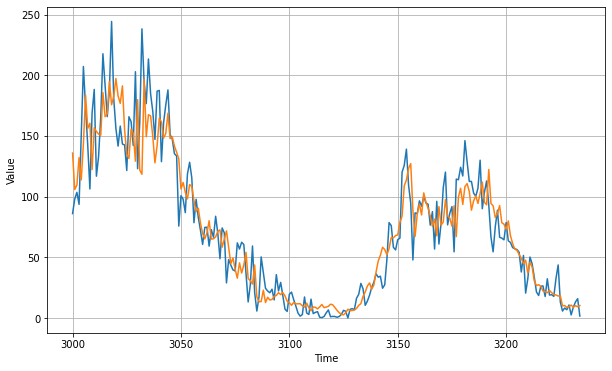

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
print('MAE: ',tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

MAE:  15.230508


<Figure size 432x288 with 0 Axes>

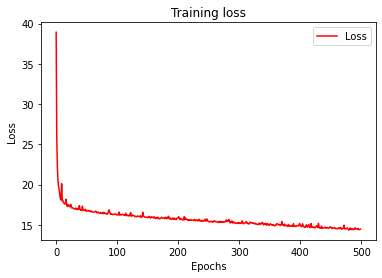

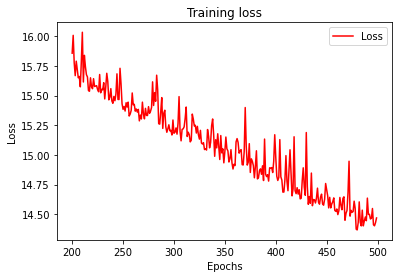

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()